In [1]:
import os

os.environ['HADOOP_HOME'] = r'/home/ubuntu/spark-2.4.7-bin-hadoop2.7/hadoop-2.7.0/'
os.environ['HADOOP_COMMON_LIB_NATIVE_DIR'] = os.environ['HADOOP_HOME'] + '/lib/native'
os.environ['HADOOP_OPTS'] = "-Djava.library.path={}/lib".format(
    os.environ['HADOOP_HOME'])

# Set up import and configure spark

In [2]:
from pyspark.sql.functions import from_unixtime, to_date, year, udf, explode, split, col, length, rank, dense_rank, avg, sum
from pyspark.sql import SparkSession
import sparknlp
import pandas as pd
pd.set_option('display.max_columns', 100, 'display.max_colwidth', 1000, 'display.max_rows', 1000,
              'display.float_format', lambda x: '%.2f' % x)

spark = SparkSession.builder \
    .master("local[*]")\
    .config("spark.driver.memory", "4G")\
    .config("spark.driver.maxResultSize", "2G") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5")\
    .config("spark.kryoserializer.buffer.max", "1G")\
    .getOrCreate()

In [3]:
import tempfile
import os
import sparknlp
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import random
import string
import csv
import numpy as np
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel, SVMWithSGD, LogisticRegressionWithSGD
from pyspark.ml.feature import HashingTF, Tokenizer

%matplotlib inline
# If difficulty in import sc or SparkContext Manually
# Please uncomment the following to do so
#import pyspark
#sc = pyspark.SparkContext('local[*]')

plt.rcdefaults()


sparknlp.version()  # This is from JohnSnowLab

'2.6.3'

# Load the training and testing JSON files

In [4]:
def load_json(file_location):
    file_type = "json"

    # CSV options
    infer_schema = "false"
    first_row_is_header = "false"
    delimiter = ","

    # The applied options are for CSV files. For other file types, these will be ignored.
    return spark.read.format(file_type) \
        .option("inferSchema", infer_schema) \
        .option("header", first_row_is_header) \
        .option("sep", delimiter) \
        .load(file_location)

Load training data

In [5]:
train_reviews = load_json(
    "/home/ubuntu/notebooks/sample_amazon_review_5_train.json")

Load testing data

In [6]:
test_reviews = load_json(
    "/home/ubuntu/notebooks/sampled_amazon_review_5_val.json")

In [7]:
# Ensure reading from disk does not happen more than once
train_reviews.cache()
test_reviews.cache()

DataFrame[asin: string, image: array<string>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, style: struct<Capacity::string,Color Name::string,Color::string,Colorj::string,Configuration::string,Connectivity::string,Design::string,Diameter::string,Digital Storage Capacity::string,Display Height::string,Edition::string,Flavor Name::string,Flavor::string,Flex::string,Format::string,Gem Type::string,Gift Amount::string,Grip Type::string,Hand Orientation::string,Item Display Length::string,Item Display Weight::string,Item Package Quantity::string,Item Shape::string,Length::string,Loft::string,Material Type::string,Material::string,Metal Stamp::string,Metal Type::string,Model Number::string,Model::string,Number of Items::string,Offer Type::string,Outside Diameter::string,Overall Length::string,Package Quantity::string,Package Type::string,Part Number::string,Pattern::string,Platform for Display::string,Platform::string,Preamplifier Output C

In [8]:
# Create a view of train and test
train_reviews.createOrReplaceTempView("train_reviews")
test_reviews.createOrReplaceTempView("test_reviews")

In [9]:
spark.sql('select reviewText, overall from train_reviews').toPandas()

,reviewText,overall
0,"This is a great start, and a very cool example of the potential of Echo in a connected home. It's not perfect, though, and I don't get the sense that the Garageio manufacturer is incrementally enhancing this skill - I fear that's it's as good as its going to get.\n\nIssue #1\n\nEach garage door is given a name. I have one with my name and one with my wife's name. Our names are both single syllable, but start with different letters and have completely different phenomes.\n\nMe: Alexa, ask garageio to close Dean's door.\nEcho: Closing Mary's door.\nMe: What the heck?!?\n\nIt happens all the time, even when standing right next to the Echo. Sure, I could rename the doors to something that the Echo can distinguish between, but it shouldn't be necessary. I recognize that this is likely an Amazon thing and not a Garageio thing, but the fact that Echo sits in my house and can't distinguish between the spoken names of two residents in the home is kinda sad.\n\nIssue #2\n\nWe have thre...",2.00
1,I've played the game a handful of times and its rare it actually gets my animal right. It takes the same general concept of 21 questions but the pay off is never there.,1.00
2,I have been using automatic for more than a year and Alexa took it to another next level . This skill can even do more based our historic driving data and also using the driving score.,4.00
3,Exactly what I needed for my mother!,5.00
4,"It does not tell you when the reruns are on., only the next show you in the series. Not bad but not usefull if you want to watch sonething like love it or list it or sone other show that does mot need to be the newest show. It woukd also be nice to be able to set your cable company and fet actual channels, yo be hobest if I have to look up what network is on what channel I may as well look up the time too. Other then those things it does work as stated",3.00
...,...,...
359988,"Editing has been done and corrections made so the 5 stars are now well and truly worth it. Once again Halloween LaVue has gotten into more trouble than you can shake a stick at, or in this case a wedding dress at. This time though Halloweens mum and BFF are also affected. That doesn't go down well at all.",5.00
359989,Thank you,5.00
359990,Beautiful shirt!! It is super cute and fits so nicely. It hangs beautifully on me. Absolutely love it. It isn't to thick and it's not too thin either it is just right and the garments stitching is good. It is a high quality shirt. Absolutely love the material. It is super soft.,5.00
359991,"Top was too big, bottoms too small, cheaply made",1.00


Filter out null reviews

In [10]:
train_reviews = train_reviews.filter(train_reviews.reviewText.isNotNull())
test_reviews = test_reviews.filter(test_reviews.reviewText.isNotNull())

reviews.createOrReplaceTempView('reviews'): Creates a new temporary view using a SparkDataFrame in the Spark Session. If a temporary view with the same name already exists, replaces it.

In [11]:
train_reviews.createOrReplaceTempView('train_reviews')
test_reviews.createOrReplaceTempView('test_reviews')

In [12]:
spark.sql('SELECT COUNT(*) FROM train_reviews').toPandas()

,count(1)
0,359835


In [13]:
spark.sql('SELECT COUNT(*) FROM test_reviews').toPandas()

,count(1)
0,89964


# Convert Review Rating to Sentiment Label

In [14]:
from pyspark.sql.functions import lit, when, col, regexp_extract

# label all reviews with greater than 3 stars as a positive review (1), else negative (0)
labelled_train = train_reviews.withColumn(
    'overall', when(col("overall") > 3, 1).otherwise(0))
labelled_test = test_reviews.withColumn(
    'overall', when(col("overall") > 3, 1).otherwise(0))
# Drop all columns except reviewText, and sentiment label
labelled_train = labelled_train.select(
    [c for c in labelled_train.columns if c in {'reviewText', 'overall'}])
labelled_test = labelled_test.select(
    [c for c in labelled_test.columns if c in {'reviewText', 'overall'}])

# Rename overall to sentiment
labelled_train = labelled_train.withColumnRenamed("overall", "sentiment")
labelled_test = labelled_test.withColumnRenamed("overall", "sentiment")

labelled_train.toPandas()

,sentiment,reviewText
0,0,"This is a great start, and a very cool example of the potential of Echo in a connected home. It's not perfect, though, and I don't get the sense that the Garageio manufacturer is incrementally enhancing this skill - I fear that's it's as good as its going to get.\n\nIssue #1\n\nEach garage door is given a name. I have one with my name and one with my wife's name. Our names are both single syllable, but start with different letters and have completely different phenomes.\n\nMe: Alexa, ask garageio to close Dean's door.\nEcho: Closing Mary's door.\nMe: What the heck?!?\n\nIt happens all the time, even when standing right next to the Echo. Sure, I could rename the doors to something that the Echo can distinguish between, but it shouldn't be necessary. I recognize that this is likely an Amazon thing and not a Garageio thing, but the fact that Echo sits in my house and can't distinguish between the spoken names of two residents in the home is kinda sad.\n\nIssue #2\n\nWe have thre..."
1,0,I've played the game a handful of times and its rare it actually gets my animal right. It takes the same general concept of 21 questions but the pay off is never there.
2,1,I have been using automatic for more than a year and Alexa took it to another next level . This skill can even do more based our historic driving data and also using the driving score.
3,1,Exactly what I needed for my mother!
4,0,"It does not tell you when the reruns are on., only the next show you in the series. Not bad but not usefull if you want to watch sonething like love it or list it or sone other show that does mot need to be the newest show. It woukd also be nice to be able to set your cable company and fet actual channels, yo be hobest if I have to look up what network is on what channel I may as well look up the time too. Other then those things it does work as stated"
...,...,...
359830,1,"Editing has been done and corrections made so the 5 stars are now well and truly worth it. Once again Halloween LaVue has gotten into more trouble than you can shake a stick at, or in this case a wedding dress at. This time though Halloweens mum and BFF are also affected. That doesn't go down well at all."
359831,1,Thank you
359832,1,Beautiful shirt!! It is super cute and fits so nicely. It hangs beautifully on me. Absolutely love it. It isn't to thick and it's not too thin either it is just right and the garments stitching is good. It is a high quality shirt. Absolutely love the material. It is super soft.
359833,0,"Top was too big, bottoms too small, cheaply made"


In [15]:
# need equal number of negative and positive reviews
labelled_train.createOrReplaceTempView('labelled_train')
labelled_test.createOrReplaceTempView('labelled_test')

### Ensure there is not an imbalance in number of positive/negative reviews

Sample a random number of reviews from the larger class to match the smaller class

In [16]:
def balance_reviews(table_name):
    query = '''
    SELECT *
    FROM {}
    WHERE sentiment='{}'
    '''
    poscount = spark.sql(query.format(table_name, 1)).count()
    print("numPositive: " + str(poscount))

    negcount = spark.sql(query.format(table_name, 0)).count()
    print("numNegative: " + str(negcount))

    query = '''
        (SELECT *
        FROM {}
        WHERE sentiment='0'
        ORDER BY RAND() LIMIT {})
        UNION
        (SELECT *
        FROM {}
        WHERE sentiment='1'
        ORDER BY RAND() LIMIT {})
        '''.format(table_name, min(poscount, negcount), table_name, min(poscount, negcount))

    sampled_reviews = spark.sql(query)
    sampled_reviews.createOrReplaceTempView(table_name)
    return sampled_reviews

In [17]:
sampled_train_reviews = balance_reviews('labelled_train')
sampled_test_reviews = balance_reviews('labelled_test')

numPositive: 293317
numNegative: 66518
numPositive: 73453
numNegative: 16511


Compare number of positive and negative reviews after downsampling

In [18]:
query = '''
SELECT COUNT(*)
FROM labelled_train
WHERE sentiment='0'
'''
print(spark.sql(query).show())

query = '''
SELECT COUNT(*)
FROM labelled_train
WHERE sentiment='1'
'''
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|   65524|
+--------+

None
+--------+
|count(1)|
+--------+
|   62710|
+--------+



In [19]:
query = '''
SELECT COUNT(*)
FROM labelled_test
WHERE sentiment='0'
'''
print(spark.sql(query).show())

query = '''
SELECT COUNT(*)
FROM labelled_test
WHERE sentiment='1'
'''
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|   16362|
+--------+

None
+--------+
|count(1)|
+--------+
|   15821|
+--------+



In [20]:
print(sampled_train_reviews.count())
sampled_test_reviews.count()

128234


32183

## Clean Data

In [21]:
import re
from html import unescape

sw = stopwords.words("english")


def remove_stopwords(x):
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string


def lower(text):
    return text.lower()


def removePunctuation(text):
    return re.sub('[^A-Za-z0-9 ]+', '', text)


@udf
def fixHTML(text):
    return unescape(text)


# UDF = user defined function
nosw = udf(remove_stopwords)
rp = udf(removePunctuation)
lc = udf(lower)
# Register UDF with Spark
spark.udf.register("nosw", nosw)
spark.udf.register("rp", rp)
spark.udf.register("lc", lc)

# Creates a new column in reviews which contains the review with no stop words
sampled_train_reviews = sampled_train_reviews.withColumn(
    'text_nosw', lc(rp(fixHTML(nosw('reviewText')))))
sampled_test_reviews = sampled_test_reviews.withColumn(
    'text_nosw', lc(rp(fixHTML(nosw('reviewText')))))

Label reviews

In [22]:
sampled_train_reviews.show()

+---------+--------------------+--------------------+
|sentiment|          reviewText|           text_nosw|
+---------+--------------------+--------------------+
|        0|I thought this wa...|thought great bou...|
|        0|Really need to qu...|really need quart...|
|        0|These are very ba...|bad figured would...|
|        0|I read this book ...|read book coverto...|
|        0|Somewhat obvious ...|somewhat obvious ...|
|        0|Design is good bu...|design good size ...|
|        0|Requested and got...|requested got app...|
|        0|I have taken step...|taken steps retur...|
|        0|I should have rea...|read reviews care...|
|        0|I was able to rea...|able read 40 put ...|
|        0|Too big and long ...|big long bullky f...|
|        0|These are very so...|soft see through ...|
|        0|I really like cha...|really like chai ...|
|        0|Squeakers stopped...|squeakers stopped...|
|        0|I've been a long ...|ive long time use...|
|        0|I have 5 cats and

# Set up helper functions

In [23]:
sc = spark.sparkContext
##############################################
# Compute Ngram


def comp_ngram(df, ngram=2, input_col="split_text", output_col="ngram"):
    from pyspark.ml.feature import NGram

    ngram = NGram(n=ngram, inputCol=input_col, outputCol=output_col)
    return ngram.transform(df)


##############################################
# Compute TF

def CompTF(gram_df, input_col="ngram", output_col="tf", num_features=1 << 18):
    # now make term frequency vectors out of data frame to feed machine
    from pyspark.ml.feature import HashingTF
    hashingtf = HashingTF(inputCol=input_col,
                          outputCol=output_col, numFeatures=num_features)
    return hashingtf.transform(gram_df)


##############################################
# Compute IDF

def CompIDF(tf, input_col="tf", output_col="idftf", minDocFreq=5):
    from pyspark.ml.feature import IDF
    tf.cache()

    idf = IDF(inputCol=input_col, outputCol=output_col, minDocFreq=5)
    idfModel = idf.fit(tf)
    return idfModel

##############################################
# Compute TFIDF


def CompTFIDF(tf, idf):
    tfidf = idf.transform(tf)
    return tfidf

##############################################
# Feature Extraction


def Convert_to_LabeledPoint(dataset):
    return dataset.rdd.map(lambda x: LabeledPoint(
        float(x.sentiment), MLLibVectors.fromML(x.idftf)))


############################################
# Testing


def test(model, dataset):
    predictionAndLabel = dataset.map(
        lambda x: (x.label, model.predict(x.features)))

    return 1.0 * predictionAndLabel.filter(lambda x: x[0] == x[1]).count() / dataset.count()

##############################################
# Testing with pred prob


def test_wpp(model, labels, features):
    labels_and_probs = labels.zip(model.predict(features)).map(
        lambda x: {"actual": float(x[0]), "probs": float(x[1])})
    return labels_and_probs

#################################
# Final Test


def test_final(model, dataset):
    labels_and_preds = dataset.map(
        lambda x: {"actual": float(x.label), "predicted": float(model.predict(x.features))})
    acc = 100.0 * \
        ((labels_and_preds.filter(
            lambda x: x["actual"] == x["predicted"]).count()) / (dataset.count()))
    return (labels_and_preds, acc)

#############################
# tpr and fpr


def tf(labels_and_preds):
    true_pos = (labels_and_preds.filter(
        lambda x: x["predicted"] == 1 and x["actual"] == 1).count())
    true_neg = (labels_and_preds.filter(
        lambda x: x["predicted"] == 0 and x["actual"] == 0).count())
    false_pos = (labels_and_preds.filter(
        lambda x: x["predicted"] == 1 and x["actual"] == 0).count())
    false_neg = (labels_and_preds.filter(
        lambda x: x["predicted"] == 0 and x["actual"] == 1).count())

    tpr = (true_pos)/(true_pos+false_neg)
    fpr = (false_pos)/(false_pos+true_neg)
    return (tpr, fpr)

# Tokenize the input

In [24]:
tokenizer = Tokenizer(inputCol="text_nosw", outputCol="split_text")
tokenized_train = tokenizer.transform(sampled_train_reviews)
tokenized_test = tokenizer.transform(sampled_test_reviews)

# Cache tokenized dataset as it will be re-used a lot
tokenized_train.cache()
tokenized_test.cache()

DataFrame[sentiment: int, reviewText: string, text_nosw: string, split_text: array<string>]

In [25]:
tokenized_train.show()

+---------+--------------------+--------------------+--------------------+
|sentiment|          reviewText|           text_nosw|          split_text|
+---------+--------------------+--------------------+--------------------+
|        0|I thought this wa...|thought great bou...|[thought, great, ...|
|        0|Really need to qu...|really need quart...|[really, need, qu...|
|        0|These are very ba...|bad figured would...|[bad, figured, wo...|
|        0|I read this book ...|read book coverto...|[read, book, cove...|
|        0|Somewhat obvious ...|somewhat obvious ...|[somewhat, obviou...|
|        0|Design is good bu...|design good size ...|[design, good, si...|
|        0|Requested and got...|requested got app...|[requested, got, ...|
|        0|I have taken step...|taken steps retur...|[taken, steps, re...|
|        0|I should have rea...|read reviews care...|[read, reviews, c...|
|        0|I was able to rea...|able read 40 put ...|[able, read, 40, ...|
|        0|Too big and lo

# Extract features from text

To start we use TFIDF, or term frequency–inverse document frequency, to extract features from the text. Later we will try different methods that come with Spark

In [26]:
def construct_tfidf_input(tokenized_train, tokenized_test, ngram=2, num_features=1 << 18):
    # now make n-gram input
    train_gram_df = comp_ngram(tokenized_train, ngram=ngram)
    test_gram_df = comp_ngram(tokenized_test, ngram=ngram)

    # now make term frequency vectors out of data frame to feed machine
    train_tf_df = CompTF(train_gram_df, num_features=num_features)
    test_tf_df = CompTF(test_gram_df, num_features=num_features)

    # tf-idf
    train_idfModel = CompIDF(train_tf_df)
    test_idfModel = CompIDF(test_tf_df)

    tfidf_train = CompTFIDF(train_tf_df, train_idfModel)
    # Use the train idf model as there are more samples, thus probably more representative
    tfidf_test = CompTFIDF(test_tf_df, train_idfModel)
    return tfidf_train, tfidf_test

In [27]:
# convert dataframe to rdd, to make a LabeledPoint tuple(label, feature, vector) for machine
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.mllib.regression import LabeledPoint

# After experimentation, ngram = 1 and num_features=5000 gave best for NB
tfidf_train, tfidf_test = construct_tfidf_input(
    tokenized_train, tokenized_test, ngram=1, num_features=5000)

# we also need to convert ml.sparsevector mllib.sparse vector, because naive bayes only accepts mllib.sparsevector type
train_dataset = tfidf_train.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.idftf)))

test_dataset = tfidf_test.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.idftf)))

In [28]:
tfidf_train.toPandas()

,sentiment,reviewText,text_nosw,split_text,ngram,tf,idftf
0,0,I thought this was great when I bought it. Then I used it ONCE and washed it and it literally fell apart...it cracked down the middle and is now worthless...what a waste of money.,thought great bought it used washed literally fell apartit cracked middle worthlesswhat waste money,"[thought, great, bought, it, , used, washed, literally, fell, apartit, cracked, middle, worthlesswhat, waste, money]","[thought, great, bought, it, , used, washed, literally, fell, apartit, cracked, middle, worthlesswhat, waste, money]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1816396176134414, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,0,Really need to quarter potatoes or size accordingly. Not designed for large chunks. Feels flimsy but works okay.,really need quarter potatoes size accordingly designed large chunks feels flimsy works okay,"[really, need, quarter, potatoes, size, accordingly, designed, large, chunks, feels, flimsy, works, okay]","[really, need, quarter, potatoes, size, accordingly, designed, large, chunks, feels, flimsy, works, okay]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,0,"These are very bad. I figured that they would be iffy coming from China but these don't even fit my Stihl ms362. OK, I figured I would just swap the orings from the new caps to my originals. Lol the orings on these new caps is some type material I've never seen before. They look like a gasket cut from the sidewall of a tire. All of these caps on Amazon look & cost about the same. Save yourself some trouble and get real ones from a dealer.",bad figured would iffy coming china even fit stihl ms362 ok figured would swap orings new caps originals lol orings new caps type material ive never seen before look like gasket cut sidewall tire caps amazon look cost same save trouble get real ones dealer,"[bad, figured, would, iffy, coming, china, even, fit, stihl, ms362, ok, figured, would, swap, orings, new, caps, originals, lol, orings, new, caps, type, material, ive, never, seen, before, look, like, gasket, cut, sidewall, tire, caps, amaz

# Naive Bayes Classification

In [29]:
# create Model
# now train and save the model
from pyspark.mllib.classification import NaiveBayes
import shutil

# training
print("************************TRAINING*******************************")
model_train_NB = NaiveBayes.train(train_dataset)
print("*****************************TRAINING COMPLETE************************************")

************************TRAINING*******************************
*****************************TRAINING COMPLETE************************************


In [30]:
# testing NB with training data

accuracy_NB_train = test(model_train_NB, train_dataset)

print("TRAINING ACCURACY:-\n")

print("The accuracy for the training dataset tested on the training data itself using NB is",
      accuracy_NB_train, "%")

print("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using NB is 0.7872795046555515 %




In [31]:
labels_and_preds_NB, accu_NB = test_final(model_train_NB, test_dataset)


print("TESTING ACCURACY:-\n")

print("The accuracy for the testing dataset using NB is", accu_NB, "%")

print("\n")

TESTING ACCURACY:-

The accuracy for the testing dataset using NB is 77.43218469378243 %




Let's look at what the model predicted vs actual label

In [32]:
def display_test_predictions(labels_and_preds):
    from pyspark.sql.functions import monotonically_increasing_id

    labels_and_preds = labels_and_preds.toDF()

    df1 = tokenized_test.withColumn("id", monotonically_increasing_id())

    df2 = labels_and_preds.withColumn("id", monotonically_increasing_id())

    return df2.join(df1, "id", "outer").drop("id")


display_test_predictions(labels_and_preds_NB).toPandas()

/home/ubuntu/venv/lib/python3.6/site-packages/pyspark/sql/session.py:401: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


,actual,predicted,sentiment,reviewText,text_nosw,split_text
0,0.00,0.00,0,"It seems like if you bump these at all, the suction comes loose, so don't rummage around in your fridge! Not a very secure lid.",seems like bump all suction comes loose rummage around fridge secure lid,"[seems, like, bump, all, suction, comes, loose, rummage, around, fridge, , secure, lid]"
1,0.00,0.00,0,Iv tried everything to get this thing to link with my truck just don't work,iv tried everything get thing link truck work,"[iv, tried, everything, get, thing, link, truck, work]"
2,0.00,0.00,0,"A lot of the reviews say that it smells really bad. While I do smell the smell, it wasn't all that bad to me and it goes away after a while. I don't know if I just have a bad sense of smell or what but it wasn't a big deal to me. It works well as a case, but my only problem is that there aren't a lot of good pockets for games. There are two smaller pockets, but I can't put all my games in there because they could fall out (which would make me really sad!). It keeps my 2ds safe though which is the most important part. For the price is was pretty decent.",lot reviews say smells really bad smell smell bad goes away while know bad sense smell big deal me works well case problem lot good pockets games two smaller pockets cant put games could fall which would make really sad keeps 2ds safe though important part price pretty decent,"[lot, reviews, say, smells, really, bad, smell, smell, bad, goes, away, while, know, bad, sense, smell, big, deal, me, works, well, case, problem, lot, good, pockets, games, two, smaller, pockets, cant, put, games, could, fall, which, would, make, really, sad, keeps, 2ds, safe, though, important, part, price, pretty, decent]"
3,0.00,0.00,0,"This pencil sucks... It reminds me of a pencil or pen you get when you buy a cheap purse or day planner, no eraser.. For the price of this pen you can buy a set of 3 really nice pencils. Awkward to hold and it is slippery, I took a file and scratched it up just to keep it from slipping.",pencil sucks reminds pencil pen get buy cheap purse day planner eraser price pen buy set 3 really nice pencils awkward hold slippery took file scratched keep slipping,"[pencil, sucks, reminds, pencil, pen, get, buy, cheap, purse, day, planner, eraser, price, pen, buy, set, 3, really, nice, pencils, awkward, hold, slippery, took, file, scratched, keep, slipping]"
4,0.00,1.00,0,"I am a HUGE This Man fan, I mean like I've read the series 4 times kind of fan! So my expectations for this series were pretty high! It wasn't quite up there with This Man, I can tell JEM has a thing for big secrets, this one was kind of predictble. Also, JEM took some cues from Sylvia Day and her Crossfire series. Gay best friend, nickname Baby Girl, parental figure who takes care of said best friend, gorgeous 'airy' mother...not that it's a bad thing but it was very obvious. I didn't hate it, but I won't be reading it as much as I read This Man.",huge man fan mean like ive read series 4 times kind fan expectations series pretty high quite man tell jem thing big secrets one kind predictble also jem took cues sylvia day crossfire series gay best friend nickname baby girl parental figure takes care said best friend gorgeous airy mothernot bad thing obvious hate it reading much read man,"[huge, man, fan, mean, like, ive, read, series, 4, times, kind, fan, expectations, series, pretty, high, quite, man, tell, jem, thing, big, secrets, one, kind, predictble, also, jem, took, cues, sylvia, day, crossfire, series, gay, best, friend, nickname, baby, girl, parental, figure, takes, care, said, best, friend, gorgeous, airy, mothernot, bad, thing, obvious, hate, it, reading, much, read, man]"
...,...,...,...,...,...,...
32178,1.00,1.00,1,"Even though this book is kinda short, it is packed with awesome information. It is all about how you can 'rewire' your brain to become a happier and more productive being.\nIt is not just about this 'think positive'- clich bu

### Find best ngram

ngram = 1 provides the best test accuracy. I'm not sure why this is as higher order n-grams should carry more word context. This could possibly due to over-fitting

In [33]:
for i in range(1, 6):
    tfidf_train, tfidf_test = construct_tfidf_input(
        tokenized_train, tokenized_test, ngram=i)

    train_dataset_ngram = tfidf_train.rdd.map(lambda x: LabeledPoint(
        float(x.sentiment), MLLibVectors.fromML(x.idftf)))
    test_dataset_ngram = tfidf_test.rdd.map(lambda x: LabeledPoint(
        float(x.sentiment), MLLibVectors.fromML(x.idftf)))

    model_train_NB = NaiveBayes.train(train_dataset_ngram)
    accuracy = test(model_train_NB, test_dataset_ngram)
    print("NB accuracy with ngram {} is {}".format(i, accuracy))

NB accuracy with ngram 1 is 0.782089923251406
NB accuracy with ngram 2 is 0.7118043687661187
NB accuracy with ngram 3 is 0.559519000714663
NB accuracy with ngram 4 is 0.5109840599074045
NB accuracy with ngram 5 is 0.4947643165646459


### Word2Vec

Let's try comparing accuracy between using tfidf/ngram and Word2Vec. Word2Vec maps each word to a vector with a specified size

In [34]:
from pyspark.ml.feature import Word2Vec, MinMaxScaler


def constructWord2VecData(train_set, test_set, vector_size=500, minCount=2):
    # create an average word vector for each document
    word2vec = Word2Vec(vectorSize=vector_size, minCount=minCount,
                        inputCol='split_text', outputCol='word2vec')
    model = word2vec.fit(train_set)
    train_vec = model.transform(train_set)
    model = word2vec.fit(test_set)
    test_vec = model.transform(test_set)

    scaler = MinMaxScaler(inputCol="word2vec", outputCol="scaledFeatures")
    scaled_train = scaler.fit(train_vec).transform(train_vec)
    scaled_test = scaler.fit(test_vec).transform(test_vec)
    return scaled_train, scaled_test


scaled_train, scaled_test = constructWord2VecData(
    tokenized_train, tokenized_test)

In [35]:
scaled_train.show()

+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|sentiment|          reviewText|           text_nosw|          split_text|            word2vec|      scaledFeatures|
+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        0|I thought this wa...|thought great bou...|[thought, great, ...|[0.02890645423904...|[0.53915877262923...|
|        0|Really need to qu...|really need quart...|[really, need, qu...|[0.01851281032969...|[0.52032705397578...|
|        0|These are very ba...|bad figured would...|[bad, figured, wo...|[0.00561650239599...|[0.49696088472908...|
|        0|I read this book ...|read book coverto...|[read, book, cove...|[0.02560920477085...|[0.53318465278669...|
|        0|Somewhat obvious ...|somewhat obvious ...|[somewhat, obviou...|[0.03069307585246...|[0.54239586212909...|
|        0|Design is good bu...|design good size ...|[design, go

In [36]:
train_dataset_vec = scaled_train.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.scaledFeatures)))
test_dataset_vec = scaled_test.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.scaledFeatures)))

In [37]:
model_train_NB_vec = NaiveBayes.train(train_dataset_vec)
train_accuracy = test(model_train_NB_vec, train_dataset_vec)
print("NB accuracy on train dataset with word2vec is {}".format(train_accuracy))
accuracy = test(model_train_NB_vec, test_dataset_vec)
print("NB accuracy on test dataset with word2vec is {}".format(accuracy))

NB accuracy on train dataset with word2vec is 0.7082287068952072
NB accuracy on test dataset with word2vec is 0.5824814342976106


Accuracy on Word2Vec is generally quite poor

## Try CountVectorizer

CountVectorizer turns out to be a little bit better than HashingTF

In [38]:
# Try count vectorizer instead of Hashing TF
from pyspark.ml.feature import CountVectorizer


def constructCVInput(tokenized_train, tokenized_test):
    # now make n-gram input
    train_gram_df = comp_ngram(tokenized_train, ngram=2)
    test_gram_df = comp_ngram(tokenized_test, ngram=2)

    # now make term frequency vectors out of data frame to feed machine
    count_vectorizer = CountVectorizer(
        vocabSize=20000, inputCol="split_text", outputCol="tf")
    train_cv_model = count_vectorizer.fit(tokenized_train)
    train_cv = train_cv_model.transform(tokenized_train)
    test_cv = train_cv_model.transform(tokenized_test)

    # tf-idf
    train_idfModel = CompIDF(train_cv)
    test_idfModel = CompIDF(test_cv)

    tfidf_train = CompTFIDF(train_cv, train_idfModel)
    tfidf_test = CompTFIDF(test_cv, test_idfModel)
    return tfidf_train, tfidf_test

count_vec_train, count_vec_test = constructCVInput(tokenized_train, tokenized_test)
count_vec_train = count_vec_train.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.idftf)))
count_vec_test = count_vec_test.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.idftf)))

model_train_NB_vec = NaiveBayes.train(count_vec_train)
train_accuracy = test(model_train_NB_vec, count_vec_train)
print("NB accuracy on train dataset with CountVectorizer is {}".format(train_accuracy))
accuracy = test(model_train_NB_vec, count_vec_test)
print("NB accuracy on test dataset with CountVectorizer is {}".format(accuracy))

NB accuracy on train dataset with CountVectorizer is 0.8146201475427733
NB accuracy on test dataset with CountVectorizer is 0.7902930118385483


## Naive Bayes More stats

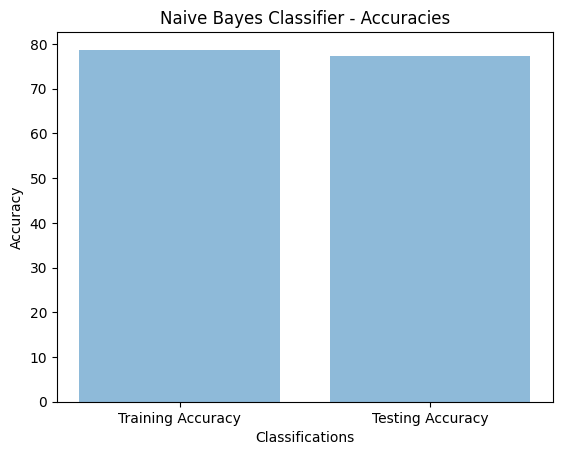

In [39]:
objects = ('Training Accuracy', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_NB_train * 100, accu_NB]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Classifier - Accuracies')

plt.show()

Here we calculate more advanced metrics to ensure our model is actually generalizing and not just predicting 1 or 0 every time

In [40]:
metrics = MulticlassMetrics(labels_and_preds_NB.map(
    lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_NB\n")
# Statistics by class
labels = (sc.parallelize(
    [row[0] for row in sampled_test_reviews.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_NB = %s" % (label, metrics.precision(label)))
    print("Class %s recall_NB = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_NB = %s" %
          (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\nAvg/Weighted recall_NB = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_NB = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_NB = %s" % metrics.weightedFMeasure())

cm = metrics.confusionMatrix().toArray()
print("\nConfusion matrix_NB=")
print(cm)
print("\n")
metrics2 = BinaryClassificationMetrics(
    labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))

# Area under ROC curve
print("Area under ROC_NB = %s" % metrics2.areaUnderROC)


Summary Stats_NB

Class 0 precision_NB = 0.7894636380988739
Class 0 recall_NB = 0.7583425009167584
Class 0 F1 Measure_NB = 0.7735901991957356
Class 1 precision_NB = 0.7598688206000243
Class 1 recall_NB = 0.7908476076101384
Class 1 F1 Measure_NB = 0.7750487812432248

Avg/Weighted recall_NB = 0.7743218469378244
Avg/Weighted precision_NB = 0.7749149755239336
Avg/Weighted F(1) Score_NB = 0.7743072307519401

Confusion matrix_NB=
[[12408.  3954.]
 [ 3309. 12512.]]


Area under ROC_NB = 0.7745950542634484


# Logistic Regression

In [41]:
#######################################################
# Accuracy of Training data using train.csv itself using LG
# training
print("************************TRAINING*******************************")
model_train_LG = LogisticRegressionWithSGD.train(
    train_dataset, iterations=10, regType='l2')
print("*****************************TRAINING COMPLETE************************************")

************************TRAINING*******************************
*****************************TRAINING COMPLETE************************************


In [42]:
# testing NB with training data

accuracy_LG_train = test(model_train_LG, train_dataset)

print("TRAINING ACCURACY:-\n")

print("The accuracy for the training dataset tested on the training data itself using LG is",
      accuracy_LG_train, "%")

print("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using LG is 0.7914827580828797 %




In [43]:
labels_and_preds_LG, accu_LG = test_final(model_train_LG, test_dataset)

print("TESTING ACCURACY:-\n")

print("The accuracy for the testing dataset using LG is", accu_LG, "%")

print("\n")

TESTING ACCURACY:-

The accuracy for the testing dataset using LG is 78.56321660503993 %




### Try pyspark ml Logistic Regression instead of Pyspark mllib

In [44]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr_model = LogisticRegression(
    labelCol='sentiment', featuresCol='idftf', maxIter=100, regParam=0.7).fit(tfidf_train)

In [45]:
prediction_train = lr_model.transform(tfidf_train)
prediction_test = lr_model.transform(tfidf_test)

In [46]:
# evaluator = BinaryClassificationEvaluator(labelCol='sentiment')
# print(evaluator.evaluate(prediction_train))
# print(evaluator.evaluate(prediction_test))

In [47]:
train_accuracy = prediction_train.filter(
    prediction_train.sentiment == prediction_train.prediction).count() / float(tfidf_train.count())
print(train_accuracy)
test_accuracy = prediction_test.filter(
    prediction_test.sentiment == prediction_test.prediction).count() / float(tfidf_test.count())
test_accuracy

0.8876662975497918


0.5255258987664295

### Test Word2Vec with Logistic Regression

In [48]:
model_train_LG_vec = LogisticRegressionWithSGD.train(
    train_dataset_vec, iterations=100, regType='l2')
train_accuracy = test(model_train_LG_vec, train_dataset_vec)
print("LG accuracy on train dataset with word2vec is {}".format(train_accuracy))
accuracy = test(model_train_LG_vec, test_dataset_vec)
print("LG accuracy on test dataset with word2vec is {}".format(accuracy))

LG accuracy on train dataset with word2vec is 0.48902787092346806
LG accuracy on test dataset with word2vec is 0.4915949414287046


### Test CountVectorizer with Logistic Regression

In [49]:
model_train_LG_cv = LogisticRegressionWithSGD.train(count_vec_train)
train_accuracy = test(model_train_LG_cv, count_vec_train)
print("LG accuracy on train dataset with CountVectorizer is {}".format(train_accuracy))
accuracy = test(model_train_LG_cv, count_vec_test)
print("LG accuracy on test dataset with CountVectorizer is {}".format(accuracy))

LG accuracy on train dataset with CountVectorizer is 0.8272065130932514
LG accuracy on test dataset with CountVectorizer is 0.8157412298418419


### LG More Stats

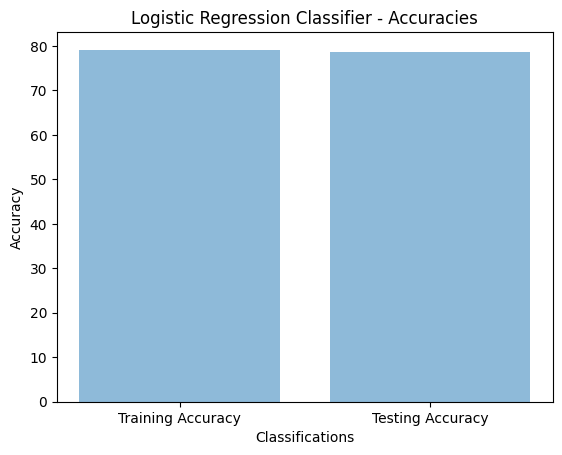

In [50]:
objects = ('Training Accuracy', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_LG_train * 100.0, accu_LG]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Classifier - Accuracies')

plt.show()

In [51]:
metrics = MulticlassMetrics(labels_and_preds_LG.map(
    lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_LG\n")
# Statistics by class
labels = (sc.parallelize(
    [row[0] for row in sampled_test_reviews.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_LG = %s" % (label, metrics.precision(label)))
    print("Class %s recall_LG = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_LG = %s" %
          (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\nAvg/Weighted recall_LG = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_LG = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_LG = %s" % metrics.weightedFMeasure())

cm = metrics.confusionMatrix().toArray()
print("\nConfusion matrix_LG=")
print(cm)
print("\n")
metrics2 = BinaryClassificationMetrics(
    labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))

# Area under ROC curve
print("Area under ROC_LG = %s" % metrics2.areaUnderROC)


Summary Stats_LG

Class 0 precision_LG = 0.8184694083596957
Class 0 recall_LG = 0.7431854296540765
Class 0 F1 Measure_LG = 0.779012780678433
Class 1 precision_LG = 0.7574743160567933
Class 1 recall_LG = 0.8295303710258517
Class 1 F1 Measure_LG = 0.7918665339246388

Avg/Weighted recall_LG = 0.7856321660503993
Avg/Weighted precision_LG = 0.788484529531612
Avg/Weighted F(1) Score_LG = 0.7853316207526406

Confusion matrix_LG=
[[12160.  4202.]
 [ 2697. 13124.]]


Area under ROC_LG = 0.7863579003399641


# Support Vector Machines

In [52]:
# Accuracy of Training data using train.csv itself using SVM

model_train_SVM = SVMWithSGD.train(train_dataset)
accuracy_SVM = test(model_train_SVM, train_dataset)
print("TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using SVM is", accuracy_SVM, "%")
print("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using SVM is 0.8115710342030975 %




In [60]:
labels_and_preds_SVM, accu_SVM = test_final(model_train_SVM, test_dataset)

print("TESTING ACCURACY:-\n")

print("The accuracy for the testing dataset using SVM is", accu_SVM, "%")

print("\n")

TESTING ACCURACY:-

The accuracy for the testing dataset using SVM is 79.96457757201007 %




In [61]:
def display_test_predictions(labels_and_preds):
    from pyspark.sql.functions import monotonically_increasing_id

    labels_and_preds = labels_and_preds.toDF()

    df1 = tokenized_test.withColumn("id", monotonically_increasing_id())

    df2 = labels_and_preds.withColumn("id", monotonically_increasing_id())

    return df2.join(df1, "id", "outer").drop("id")


display_test_predictions(labels_and_preds_SVM).toPandas()

,actual,predicted,sentiment,reviewText,text_nosw,split_text
0,0.00,0.00,0,"It seems like if you bump these at all, the suction comes loose, so don't rummage around in your fridge! Not a very secure lid.",seems like bump all suction comes loose rummage around fridge secure lid,"[seems, like, bump, all, suction, comes, loose, rummage, around, fridge, , secure, lid]"
1,0.00,0.00,0,Iv tried everything to get this thing to link with my truck just don't work,iv tried everything get thing link truck work,"[iv, tried, everything, get, thing, link, truck, work]"
2,0.00,0.00,0,"A lot of the reviews say that it smells really bad. While I do smell the smell, it wasn't all that bad to me and it goes away after a while. I don't know if I just have a bad sense of smell or what but it wasn't a big deal to me. It works well as a case, but my only problem is that there aren't a lot of good pockets for games. There are two smaller pockets, but I can't put all my games in there because they could fall out (which would make me really sad!). It keeps my 2ds safe though which is the most important part. For the price is was pretty decent.",lot reviews say smells really bad smell smell bad goes away while know bad sense smell big deal me works well case problem lot good pockets games two smaller pockets cant put games could fall which would make really sad keeps 2ds safe though important part price pretty decent,"[lot, reviews, say, smells, really, bad, smell, smell, bad, goes, away, while, know, bad, sense, smell, big, deal, me, works, well, case, problem, lot, good, pockets, games, two, smaller, pockets, cant, put, games, could, fall, which, would, make, really, sad, keeps, 2ds, safe, though, important, part, price, pretty, decent]"
3,0.00,0.00,0,"This pencil sucks... It reminds me of a pencil or pen you get when you buy a cheap purse or day planner, no eraser.. For the price of this pen you can buy a set of 3 really nice pencils. Awkward to hold and it is slippery, I took a file and scratched it up just to keep it from slipping.",pencil sucks reminds pencil pen get buy cheap purse day planner eraser price pen buy set 3 really nice pencils awkward hold slippery took file scratched keep slipping,"[pencil, sucks, reminds, pencil, pen, get, buy, cheap, purse, day, planner, eraser, price, pen, buy, set, 3, really, nice, pencils, awkward, hold, slippery, took, file, scratched, keep, slipping]"
4,0.00,1.00,0,"I am a HUGE This Man fan, I mean like I've read the series 4 times kind of fan! So my expectations for this series were pretty high! It wasn't quite up there with This Man, I can tell JEM has a thing for big secrets, this one was kind of predictble. Also, JEM took some cues from Sylvia Day and her Crossfire series. Gay best friend, nickname Baby Girl, parental figure who takes care of said best friend, gorgeous 'airy' mother...not that it's a bad thing but it was very obvious. I didn't hate it, but I won't be reading it as much as I read This Man.",huge man fan mean like ive read series 4 times kind fan expectations series pretty high quite man tell jem thing big secrets one kind predictble also jem took cues sylvia day crossfire series gay best friend nickname baby girl parental figure takes care said best friend gorgeous airy mothernot bad thing obvious hate it reading much read man,"[huge, man, fan, mean, like, ive, read, series, 4, times, kind, fan, expectations, series, pretty, high, quite, man, tell, jem, thing, big, secrets, one, kind, predictble, also, jem, took, cues, sylvia, day, crossfire, series, gay, best, friend, nickname, baby, girl, parental, figure, takes, care, said, best, friend, gorgeous, airy, mothernot, bad, thing, obvious, hate, it, reading, much, read, man]"
...,...,...,...,...,...,...
32178,1.00,0.00,1,"Even though this book is kinda short, it is packed with awesome information. It is all about how you can 'rewire' your brain to become a happier and more productive being.\nIt is not just about this 'think positive'- clich bu

### Test Word2Vec with SVM

Not sure why Word2Vec performs so terribly with SVM

In [56]:
model_train_SVM_vec = SVMWithSGD.train(train_dataset_vec)
train_accuracy = test(model_train_SVM_vec, train_dataset_vec)
print("SVM accuracy on train dataset with word2vec is {}".format(train_accuracy))
accuracy = test(model_train_SVM_vec, test_dataset_vec)
print("SVM accuracy on test dataset with word2vec is {}".format(accuracy))

SVM accuracy on train dataset with word2vec is 0.49262286133162814
SVM accuracy on test dataset with word2vec is 0.4915949414287046


### Test CountVectorizer with SVM

In [57]:
model_train_SVM_cv = SVMWithSGD.train(count_vec_train)
train_accuracy = test(model_train_SVM_cv, count_vec_train)
print("SVM accuracy on train dataset with CountVectorizer is {}".format(train_accuracy))
accuracy = test(model_train_SVM_cv, count_vec_test)
print("SVM accuracy on test dataset with CountVectorizer is {}".format(accuracy))

SVM accuracy on train dataset with CountVectorizer is 0.8368919319369278
SVM accuracy on test dataset with CountVectorizer is 0.8195009787776155


### SVM More Stats

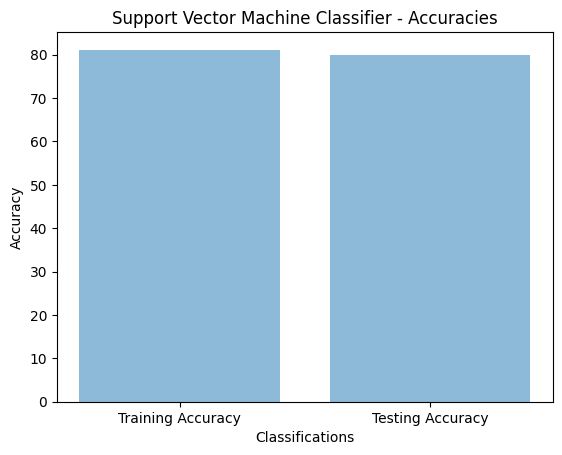

In [58]:
objects = ('Training Accuracy', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_SVM * 100, accu_SVM]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Support Vector Machine Classifier - Accuracies')

plt.show()

In [63]:
metrics = MulticlassMetrics(labels_and_preds_SVM.map(
    lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_SVM\n")
# Statistics by class
labels = (sc.parallelize(
    [row[0] for row in sampled_test_reviews.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_SVM = %s" % (label, metrics.precision(label)))
    print("Class %s recall_SVM = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_SVM = %s" %
          (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\nAvg/Weighted recall_SVM = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_SVM = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_SVM = %s" % metrics.weightedFMeasure())

cm = metrics.confusionMatrix().toArray()
print("\nConfusion matrix_SVM=")
print(cm)
print("\n")
metrics2 = BinaryClassificationMetrics(
    labels_and_preds_SVM.map(lambda x: (x["predicted"], x["actual"])))

# Area under ROC curve
print("Area under ROC_SVM = %s" % metrics2.areaUnderROC)


Summary Stats_SVM

Class 0 precision_SVM = 0.8152906754865793
Class 0 recall_SVM = 0.7834005622784501
Class 0 F1 Measure_SVM = 0.7990275526742301
Class 1 precision_SVM = 0.7847032379563817
Class 1 recall_SVM = 0.8164464951646546
Class 1 F1 Measure_SVM = 0.8002602069264606

Avg/Weighted recall_SVM = 0.7996457757201006
Avg/Weighted precision_SVM = 0.8002540459254677
Avg/Weighted F(1) Score_SVM = 0.7996335192691573

Confusion matrix_SVM=
[[12818.  3544.]
 [ 2904. 12917.]]


Area under ROC_SVM = 0.7999235287215525


# Summary

All the models performed within 3% accuracy of each other on the test set, so there is no clear winner. However, Naive Bayes gives a good baseline, but there is not really any hyper parameters to tune so we can probably get higher accuracy using Logistic regression or SVM. The purpose of this model is to train using the labeled amazon reviews and once we are happy on it's accuracy with the Amazon reviews, we can use it in a domain where there are no labels, such as determining the sentiment regarding a certain topic on Twitter. Given more time, using an LSTM RNN, Long Short-Term Memory Recurrent Neural Network, may have provided even better results as those models can generally learn more context in the reviews. Also, only a small sample of the full dataset was used to be able to run on one computer. If the full dataset was used on a cluster of computers, much better performance would most likely be obtained

# Further tuning

I chose the SVM model to try to tune further to get the highest accuracy

In [64]:
# Try count vectorizer instead of Hashing TF
from pyspark.ml.feature import CountVectorizer

# now make n-gram input
train_gram_df = comp_ngram(tokenized_train, ngram=2)
test_gram_df = comp_ngram(tokenized_test, ngram=2)


# now make term frequency vectors out of data frame to feed machine
count_vectorizer = CountVectorizer(
    vocabSize=20000, inputCol="split_text", outputCol="tf")
train_cv_model = count_vectorizer.fit(tokenized_train)
train_cv = train_cv_model.transform(tokenized_train)
test_cv = train_cv_model.transform(tokenized_test)

# tf-idf
train_idfModel = CompIDF(train_cv)
test_idfModel = CompIDF(test_cv)

tfidf_train = CompTFIDF(train_cv, train_idfModel)
tfidf_test = CompTFIDF(test_cv, test_idfModel)

In [65]:
train_dataset_cv = tfidf_train.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.idftf)))
test_dataset_cv = tfidf_test.rdd.map(lambda x: LabeledPoint(
    float(x.sentiment), MLLibVectors.fromML(x.idftf)))

In [ ]:
model_train_SVM = SVMWithSGD.train(
    train_dataset_cv, iterations=400, miniBatchFraction=0.5, regParam=0)
accuracy_SVM = test(model_train_SVM, train_dataset_cv)
print("TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using SVM is", accuracy_SVM, "%")
print("\n")

In [ ]:
labels_and_preds_SVM, accu_SVM = test_final(model_train_SVM, test_dataset_cv)

print("TESTING ACCURACY:-\n")

print("The accuracy for the testing dataset using SVM is", accu_SVM, "%")

print("\n")

The best accuracy I was able to get was 82%